# 加载数据

In [39]:
from sklearn.model_selection import StratifiedKFold,train_test_split
import torch
import  numpy
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.autograd import Variable as  V
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from torch.utils.data import DataLoader,Dataset,TensorDataset

In [40]:
def load_data():
    gtvt1 = pd.read_csv('before.csv')
    gtvt2 = pd.read_csv('after.csv')



    X1, y1 = gtvt1.loc[:, [str(before) for before in range(1,82)]].values, gtvt1.loc[:, ['Label']].values

    X2, y2 = gtvt2.loc[:, [str(after) for after in range(1,82)]].values, gtvt2.loc[:, ['Label']].values
    
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    X2 = scaler.fit_transform(X2)


    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=0.2, shuffle=True)

    X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=True)
    
    return X_train1, X_test1, Y_train1, Y_test1,X_train2, X_test2, Y_train2, Y_test2

    

In [41]:
def get_two_stream_dataloader(X_train1,Y_train1,X_test1,Y_test1,X_train2,Y_train2,X_test2,Y_test2):



    X_1_train = torch.from_numpy(X_train1.astype(numpy.float32))


    y_1_train = torch.from_numpy(Y_train1.astype(numpy.int))
    X_1_test = torch.from_numpy(X_test1.astype(numpy.float32))
    y_1_test = torch.from_numpy(Y_test1.astype(numpy.int))

    X_2_train = torch.from_numpy(X_train2.astype(numpy.float32))
    y_2_train = torch.from_numpy(Y_train2.astype(numpy.int))
    X_2_test = torch.from_numpy(X_test2.astype(numpy.float32))
    y_2_test = torch.from_numpy(Y_test2.astype(numpy.int))

    my_dataset1 = TensorDataset(X_1_train,X_2_train,y_1_train)
    my_dataset2 = TensorDataset(X_1_test, X_2_test, y_1_test)

    my_dataset_train = DataLoader(my_dataset1,batch_size=5,shuffle=False,pin_memory=True)
    my_dataset_test = DataLoader(my_dataset2, batch_size=5, shuffle=False, pin_memory=True)

    return my_dataset_train,my_dataset_test


def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)


def calAUC(prob,labels):
    f = list(zip(prob,labels))
    rank = [values2 for values1,values2 in sorted(f,key=lambda x:x[0])]
    rankList = [i+1 for i in range(len(rank)) if rank[i]==1]
    posNum = 0
    negNum = 0
    for i in range(len(labels)):
        if(labels[i]==1):
            posNum+=1
        else:
            negNum+=1
    auc = 0
    auc = (sum(rankList)- (posNum*(posNum+1))/2)/(posNum*negNum)
    return auc

In [42]:
def smote_augment_data(X_train,y_train):
    import pandas as pd
    from imblearn.over_sampling import SMOTE
    # x_columns = X_train.columns
    # y_columns = y_train.columns
    #注意过采样时 只对训练集进行过采样
    oversampler = SMOTE()
    x_smote_train,y_smote_train= oversampler.fit_sample(X_train,y_train)
    # x_smote_train = pd.DataFrame(x_smote_train, columns=x_columns)
    # y_smote_train = pd.DataFrame(y_smote_train, columns=y_columns)
    return x_smote_train,y_smote_train

from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import numpy as np

def feature_selection_rf(X_train, Y_train):
    model = RandomForestRegressor(random_state=1, max_depth=200)
    model.fit(X_train, Y_train.values.ravel())
    features = X_train.columns
    importances = model.feature_importances_
    rf_indices = np.argsort(importances)[-81:]  # top 10 features
#     rf_indices = np.argwhere(importances>0.0003)
    
    for f in range(rf_indices.shape[0]):
       print("%d. feature %d (%f)" % (f + 1, rf_indices[f], importances[rf_indices[f]]))
    #plt.title('Feature Importances')
    #plt.barh(range(len(rf_indices)), importances[rf_indices], color='b', align='center')
    #plt.yticks(range(len(rf_indices)), [features[i] for i in rf_indices])
    #plt.xlabel('Relative Importance')
    #plt.show()
    rf_features = [features[i] for i in rf_indices]
    return rf_features

# MLDRL model

In [43]:
from sklearn.model_selection import StratifiedKFold

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

import torch.optim as optim
from torch import nn
from torch.autograd import Variable as  V
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import  numpy
from  sklearn.preprocessing import MinMaxScaler,StandardScaler
from torch.utils.data import DataLoader,Dataset,TensorDataset


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder1(torch.nn.Module):
    def __init__(self, D_in, H):
        super(Encoder1, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)

    def forward(self, x):

        return F.relu(self.linear1(x))


class Decoder1(torch.nn.Module):
    def __init__(self, latent, H, D_out):
        super(Decoder1, self).__init__()
        self.linear1 = torch.nn.Linear(latent, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Encoder2(torch.nn.Module):
    def __init__(self, D_in, H):
        super(Encoder2, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)

    def forward(self, x):

        return F.relu(self.linear1(x))


class Decoder2(torch.nn.Module):
    def __init__(self, latent, H, D_out):
        super(Decoder2, self).__init__()
        self.linear1 = torch.nn.Linear(latent, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class MLDRL(torch.nn.Module):
    latent_dim = 10

    def __init__(self, encoder1, decoder1,encoder2,decoder2):
        super(MLDRL, self).__init__()
        self.encoder1 = encoder1
        self.decoder1 = decoder1
        self.encoder2 = encoder2
        self.decoder2 = decoder2
        self._enc_mu = torch.nn.Linear(32, 10)
        self._enc_log_sigma = torch.nn.Linear(32, 10)

        self.fc1 = nn.Linear(14, 2, bias=True)

        self.act = F.sigmoid

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False), mu, sigma  # Reparameterization trick

    def forward(self,x1,x2):
        h_enc1 = self.encoder1(x1)
        z1, mu1, sigma1 = self._sample_latent(h_enc1)

        comm1, spe1 = z1.split([6,4], dim=1)
        decoder1_ = self.decoder1(z1)

        h_enc2 = self.encoder2(x2)
        z2, mu2, sigma2 = self._sample_latent(h_enc2)
        comm2, spe2 = z2.split([6,4], dim=1)

        decoder2_ = self.decoder2(z2)

        connect1 = torch.cat([spe1,comm2],dim=1)
        decoder3_ = self.decoder1(connect1)
        connect2 = torch.cat([comm1,spe2],dim=1)
        decoder4_ = self.decoder2(connect2)

        inputmlp_com = (comm1 + comm2) / 2
        inputmlp = torch.cat((inputmlp_com, spe1, spe2), 1)

        out = self.act(self.fc1(inputmlp))

        out = F.softmax(out)

        return decoder1_,decoder2_,decoder3_,decoder4_,comm1,spe1,comm2,spe2,mu1,sigma1,mu2,sigma2,out,inputmlp

def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


In [54]:
def train_and_test():
    
    
    
    X_train1, X_test1, Y_train1, Y_test1,X_train2, X_test2, Y_train2, Y_test2 = load_data()
    
    dataloader_train,dataloader_test = get_two_stream_dataloader(X_train1,Y_train1,X_test1,Y_test1,X_train2,Y_train2,X_test2,Y_test2)
    
    

    
    Weightloss1 = torch.tensor(torch.FloatTensor([1.4]), requires_grad=True)
    Weightloss2 = torch.tensor(torch.FloatTensor([3]), requires_grad=True)
    Weightloss3 = torch.tensor(torch.FloatTensor([0.4]), requires_grad=True)

    params = [Weightloss1, Weightloss2, Weightloss3]


    auc_list = []
    acc_list = []
    speci_list = []
    sen_list = []


    loss_func = nn.MSELoss()
    Gradloss = nn.L1Loss()
    lam = []
    beita = []
    gama = []
    input_dim = 81
    l_list = []
    alph = 0.2
    
    encoder1 = Encoder1(input_dim,32)
    decoder1 = Decoder1(10, 32, input_dim)
    encoder2 = Encoder2(input_dim, 32)
    decoder2 = Decoder2(10, 32, input_dim)

    vae = MLDRL(encoder1,decoder1,encoder2,decoder2)

    criterion = nn.MSELoss()
    criterion1 = nn.CrossEntropyLoss()

    opt1 = optim.Adam(vae.parameters(), lr=0.000085)

    opt2 = torch.optim.Adam(params, lr=0.000085)
    l = None

    loss_comm=None
    loss_spe = None
    loss_comm_spe = None
    loss_class = None
    com_list = []
    spe_list = []
    com_spe_list = []
    classfication = []
    com_list_ = []
    spe_list_ = []
    com_spe_list_ = []
    classfication_ = []
    l_list_ = []
    Hiddle = []

    for epoch in range(50):
        for i, (data1,data2,target)  in enumerate(dataloader_train):
            sum_recon=0
            sum_spe =0
            sum_com =0
            sum_com_spe =0
            sum_class = 0
            inputs1 = data1
            inputs2 = data2


            d1,d2,d3,d4,c1,s1,c2,s2,m1,sig1,m2,sig2,pred, hiddle_final = vae(V(inputs1),V(inputs2))

            # inputmlp_com = (c1+c2)/2
            # inputmlp  = torch.cat((inputmlp_com,s1,s2),1)
            #
            # pred = MLP(inputmlp)

            target = target.squeeze()


            loss_cass = criterion1(pred,target)




            loss_comm = criterion(c1, c2)

            loss_spe = criterion(s1, s2)

            loss_comm_spe = loss_comm-loss_spe

            sum_com = sum_com+loss_comm
            sum_spe = sum_spe+loss_spe
            sum_com_spe = sum_com_spe+loss_comm_spe
            sum_class = sum_class+loss_cass

            ll1 = latent_loss(m1, sig1)
            ll2 = latent_loss(m2, sig2)

            loss1 = criterion(d1, inputs1)
            loss2 = criterion(d2, inputs2)
            loss3 = criterion(d3, inputs1)
            loss4 = criterion(d4, inputs2)
            recon = loss1+loss2+loss3+loss4
            KL = ll1+ll2
            sum_recon = sum_recon+recon
            l1 = params[0]*(recon+KL)
            l2 = params[1]*(loss_comm_spe)
            l3 = params[2]*(loss_cass)


            mean_loss = torch.div(torch.add(torch.add(l1,l2),l3),3)

            if epoch ==0:
                l01 = l1.data
                l02 = l2.data
                l03 = l3.data

            opt1.zero_grad()

            mean_loss.backward(retain_graph=True)

            # Getting gradients of the first layers of each tower and calculate their l2-norm

            param = list(vae.parameters())
            G1R_1 = torch.autograd.grad(l1, param[13], retain_graph=True, create_graph=True)
            G1R_2 = torch.autograd.grad(l1, param[15], retain_graph=True, create_graph=True)
            G1R = torch.div(torch.add(G1R_1[0],G1R_2[0]),2)
            G1 = torch.norm(G1R, 2)

            G2R_1 = torch.autograd.grad(l2, param[13], retain_graph=True, create_graph=True)
            G2R_2 = torch.autograd.grad(l2, param[15], retain_graph=True, create_graph=True)
            G2R = torch.div(torch.add(G2R_1[0], G2R_2[0]), 2)
            G2 = torch.norm(G2R, 2)


            G3R_1 = torch.autograd.grad(l3, param[13], retain_graph=True, create_graph=True)
            G3R_2 = torch.autograd.grad(l3, param[15], retain_graph=True, create_graph=True)
            G3R = torch.div(torch.add(G3R_1[0], G3R_2[0]), 2)
            G3 = torch.norm(G3R, 2)

            G_avg = torch.div(torch.add(torch.add(G1, G2), G3), 3)


            # Calculating relative losses

            lhat1 = torch.div(l1, l01)
            lhat2 = torch.div(l2, l02)
            lhat3 = torch.div(l3, l03)

            lhat_avg = torch.div(torch.add(torch.add(lhat1, lhat2),lhat3), 3)

            # Calculating relative inverse training rates for tasks
            inv_rate1 = torch.div(lhat1, lhat_avg)
            inv_rate2 = torch.div(lhat2, lhat_avg)
            inv_rate3 = torch.div(lhat3, lhat_avg)


            # Calculating the constant target for Eq. 2 in the GradNorm paper
            C1 = G_avg * (inv_rate1) ** alph
            C2 = G_avg * (inv_rate2) ** alph
            C3 = G_avg * (inv_rate3) ** alph


            C1 = C1.detach()
            C2 = C2.detach()
            C3 = C3.detach()


            opt2.zero_grad()
            Lagrad = torch.add(torch.add(Gradloss(G1,C1),Gradloss(G2,C2)),Gradloss(G3,C3))

            Lagrad.backward()

            opt2.step()
            opt1.step()

            if epoch==49:
                if i ==0:
                    c_final = (c1+c2)/2
                    sp1 = s1
                    sp2 = s2
                else:
                    c_final = torch.cat([c_final,(c1+c2)/2],dim=0)
                    sp1 = torch.cat([sp1,s1],dim=0)
                    sp2 = torch.cat([sp2,s2],dim=0)
                latent_space = torch.cat([c_final,sp1,sp2],dim=1)


        if Weightloss1<0.1:
            Weightloss1=0.01

        correct = 0
        true_test= []
        pred_test= []
        pred_pro = []

        total = len(dataloader_test.dataset)
        for i, (data3, data4, target3) in enumerate(dataloader_test):
            sum_recon_ = 0
            sum_spe_ = 0
            sum_com_ = 0
            sum_com_spe_ = 0
            sum_class_ = 0

            inputs3 = data3
            # print(inputs1)
            inputs4 = data4
            # print(inputs2)

            d1_, d2_, d3_, d4_, c1_, s1_, c2_, s2_, m1_, sig1_, m2_, sig2_ ,pred,hiddle_final = vae(V(inputs3), V(inputs4))

            # inputmlp_com_ = (c1_ + c2_) / 2
            # inputmlp_ = torch.cat((inputmlp_com_, s1_, s2_), 1)
            #
            # pred = MLP(inputmlp_)

            if epoch == 49:
                for i in range(len(hiddle_final.detach().numpy())):
                    Hiddle.append(hiddle_final.detach().numpy()[i])


            pred1 = pred.argmax(dim=1)


            target3 = target3.squeeze()

            
            loss_cass = criterion1(pred,target3)
   


            true_test  = true_test+target3.numpy().tolist()
            pred_test = pred_test+pred1.numpy().tolist()
            pred_pro = pred_pro+pred.detach().numpy().tolist()
            correct += torch.eq(pred1,target3).sum().float().item()
            loss_comm_ = criterion(c1_, c2_)

            loss_spe_ = criterion(s1_, s2_)

            ll1_ = latent_loss(m1_, sig1_)
            ll2_ = latent_loss(m2_, sig2_)

            loss1_ = criterion(d1_, inputs3)
            loss2_ = criterion(d2_, inputs4)
            loss3_ = criterion(d3_, inputs3)
            loss4_ = criterion(d4_, inputs4)
            recon_ = loss1_ + loss2_ + loss3_ + loss4_


        pred_pro_ = [i[1] for i in pred_pro]
        tp,fp,tn,fn = perf_measure(true_test,pred_test)
        print('AUC',calAUC(pred_pro_,true_test))
        print('ACC', correct / total)
        print('SEN',tp/(fn+tp))
        print('SPE',tn/(fp+tn))





        auc_list.append(calAUC(pred_pro_,true_test))
        acc_list.append(correct / total)
        sen_list.append(tp/(fn+tp))
        speci_list.append(tn/(fp+tn))

        if (epoch+1)%1 ==0:
            l_list.append(sum_recon)
            l_list_.append(recon_)
            com_list.append(sum_com)
            com_list_.append(loss_comm_)
            spe_list.append(sum_spe)
            spe_list_.append(loss_spe_)
            com_spe_list.append(sum_com_spe)
            classfication.append(sum_class)
            classfication_.append(loss_cass)
            # print(sum_recon)

        # print('epoch',epoch,params[0],params[1],params[2],params[3])
        lam.append(params[0].tolist()[0])
        beita.append(params[1].tolist()[0])
        classfication_value_1 = params[2].tolist()[0]
        gama.append(classfication_value_1)
        print('epoch',epoch)
        print(lam[epoch])
        print(beita[epoch])
        print(gama[epoch])







    torch.save(vae, 'MLDRL.pkl')

    com_title = ['com_1','com_2','com_3','com_4','com_5','com_6','sp1_1','sp1_2','sp1_3','sp1_4','sp2_1','sp2_2','sp2_3','sp2_4']
    com_csv = pd.DataFrame(columns=com_title, data=latent_space.data.numpy())
    com_csv.to_csv('latent_final.csv')
    recon_show =[]
    com_show = []
    spe_show = []
    com_spe_show = []
    class_show =[]
    for i in range(len(l_list)):
        if((i+1)%1==0):
            recon_show.append((l_list[i]+l_list[i-1]+l_list[i-2]+l_list[i-3])/4)
            com_show.append((com_list[i]+com_list[i-1]+com_list[i-2]+com_list[i-3])/4)
            spe_show.append((spe_list[i]+spe_list[i-1]+spe_list[i-2]+spe_list[i-3])/4)
            com_spe_show.append((com_spe_list[i]+com_spe_list[i-1]+com_spe_list[i-2]+com_spe_list[i-3])/4)
            class_show.append((classfication[i]+classfication[i-1]+classfication[i-2]+classfication[i-3])/4)



    x_range = range(0,50)
    plt.subplot(1,1,1)
    plt.rcParams['savefig.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.plot(x_range,l_list,'1-')
    plt.plot(x_range, l_list_, '1-')

    plt.title('recons')
    plt.ylabel('loss')

    plt.show()
    x_range = range(0, 50)
    plt.subplot(1, 1, 1)
    plt.rcParams['savefig.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.plot(x_range, com_list, '1-')
    plt.plot(x_range, com_list_, '1-')

    plt.title('com loss')
    plt.ylabel('loss')

    plt.show()

    x_range = range(0, 50)
    plt.subplot(1, 1, 1)
    plt.rcParams['savefig.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.plot(x_range, spe_list,'1-')
    plt.plot(x_range, spe_list_, '1-')

    plt.title('spe loss')
    plt.ylabel('loss')

    plt.show()



    x_range = range(0, 50)
    plt.subplot(1, 1, 1)
    plt.rcParams['savefig.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.plot(x_range, classfication, '1-')
    plt.plot(x_range, classfication_, '1-')

    plt.title('class loss')
    plt.ylabel('loss')

    plt.show()
    recon_result = []
    com_result =[]
    spe_result =[]
    class_result = []

    recon_result_ = []
    com_result_ = []
    spe_result_ = []
    class_result_ = []

    lam_result = []
    beita_result = []
    gama_result = []


    print(type(l_list))
    for i in range(len(l_list)):
        recon_result.append(l_list[i].tolist())
        com_result.append(com_list[i].tolist())
        spe_result.append(spe_list[i].tolist())
        class_result.append(classfication[i].tolist())

        recon_result_.append(l_list_[i].tolist())
        com_result_.append(com_list_[i].tolist())
        spe_result_.append(spe_list_[i].tolist())
        class_result_.append(classfication_[i].tolist())

        lam_result.append(lam[i])
        beita_result.append(beita[i])
        gama_result.append(gama[i])


  



/Users/yuehailin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is de

AUC 0.4650974025974026
ACC 0.46
SEN 0.44642857142857145
SPE 0.4772727272727273
epoch 0
1.4065943956375122
2.993469476699829
0.40584829449653625
AUC 0.3989448051948052
ACC 0.41
SEN 0.375
SPE 0.45454545454545453
epoch 1
1.412964940071106
2.990541934967041
0.4121168255805969
AUC 0.49594155844155846
ACC 0.52
SEN 0.4642857142857143
SPE 0.5909090909090909
epoch 2
1.419428825378418
2.9877569675445557
0.41814252734184265
AUC 0.4094967532467532
ACC 0.42
SEN 0.2857142857142857
SPE 0.5909090909090909
epoch 3
1.4260832071304321
2.987286329269409
0.4242412745952606
AUC 0.5300324675324676
ACC 0.5
SEN 0.4642857142857143
SPE 0.5454545454545454
epoch 4
1.4329943656921387
2.9876327514648438
0.43041157722473145
AUC 0.612012987012987
ACC 0.5
SEN 0.375
SPE 0.6590909090909091
epoch 5
1.440561294555664
2.9899895191192627
0.4367152154445648
AUC 0.36688311688311687
ACC 0.39
SEN 0.30357142857142855
SPE 0.5
epoch 6
1.4490970373153687
2.9925601482391357
0.44325536489486694
AUC 0.5434253246753247
ACC 0.48
SEN 0.26

/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MLDRL. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Decoder1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder2. It won't be checked for correctness upon loading.
  "type " + obj

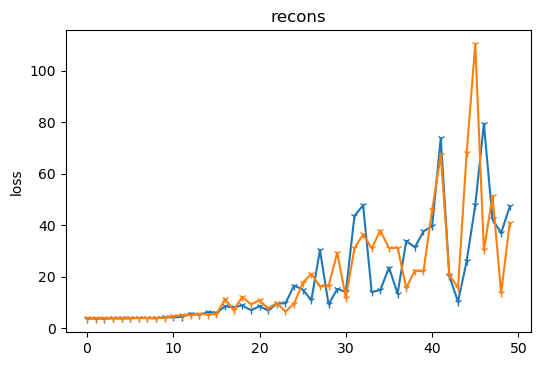

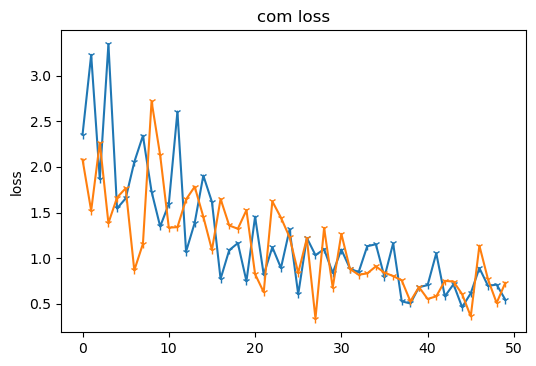

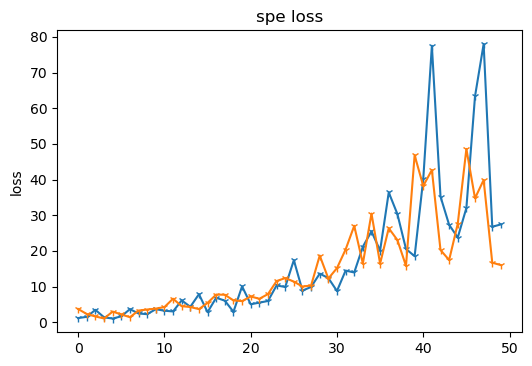

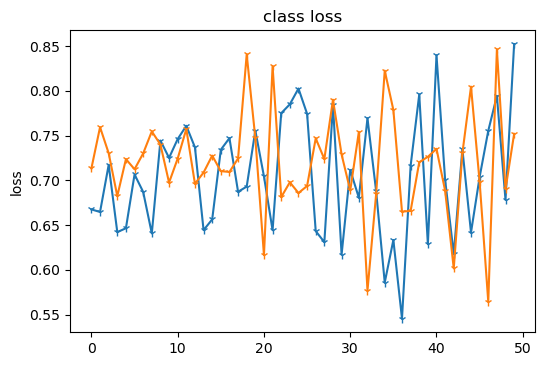

<class 'list'>


In [55]:
train_and_test()